In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table as Table
import matplotlib.pyplot as plt
from linetools.spectra import utils as ltsu
from linetools.spectra.xspectrum1d import XSpectrum1D
import astropy.units as u
from astropy import constants as const

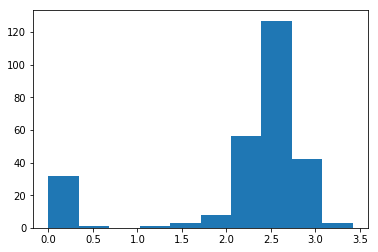

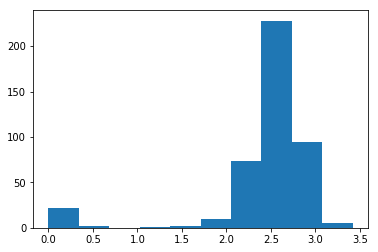

In [2]:
spec_atr_16 = Table.read('/home/jsm/PycharmProjects/Summer_Research_2018/old_spec/spec_atr.txt', format = 'ascii') 

spec_atr_17 = Table.read('/home/jsm/PycharmProjects/Summer_Research_2018/new_spec/cl2017_redux/cl2017_valueadded_release_20171009.txt', format = 'ascii') 

z_16 = [entry["zspec"] for entry in spec_atr_16]

z_17 = [entry["col5"] for entry in spec_atr_17]

plt.hist(z_16)
plt.show()

plt.hist(z_17)
plt.show()

In [3]:
#to order and match the spec with their z values
spec_atr_16 = Table.read('/home/jsm/PycharmProjects/Summer_Research_2018/old_spec/spec_atr.txt', format = 'ascii') 

#an initial filter to ensure the spec included cover lya
basestring_16 = '/home/jsm/PycharmProjects/Summer_Research_2018/old_spec/'

init_spec_16 = []

init_z_16 = []
    
for entry in spec_atr_16:
    
    if 2.00 < entry["zspec"] < 2.5: 
        
        temp = XSpectrum1D.from_file(basestring_16 + entry["Filename"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["zspec"]) < temp.wvmax:
                
            init_z_16.append(entry["zspec"])
                
            init_spec_16.append(XSpectrum1D.from_file(basestring_16 + entry["Filename"]))

In [4]:
len(init_spec_16)

111

In [5]:
#to order and match the spec with their z values
spec_atr_17 = Table.read('/home/jsm/PycharmProjects/Summer_Research_2018/new_spec/cl2017_redux/cl2017_valueadded_release_20171009.txt', format = 'ascii') 

#an initial filter to ensure the spec included cover lya
basestring_17 = '/home/jsm/PycharmProjects/Summer_Research_2018/new_spec/cl2017_redux/spec_v0/'

init_spec_17 = []

init_z_17 = []
    
for entry in spec_atr_17:
    
    if 2.00 < entry["col5"] < 2.5: 
        
        temp = XSpectrum1D.from_file(basestring_17 + entry["col1"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["col5"]) < temp.wvmax:
                
            init_z_17.append(entry["col5"])
                
            init_spec_17.append(XSpectrum1D.from_file(basestring_17 + entry["col1"]))

/home/jsm/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in greater
  *arrays, **kwargs)


In [6]:
len(init_z_17)

174

In [7]:
init_spec = np.asarray(init_spec_16 + init_spec_17)

print("Number of spectra (Nspec) after filter =", len(init_spec))

init_z = np.asarray(init_z_16 + init_z_17)

Number of spectra (Nspec) after filter = 285


In [8]:
max_z = max(init_z)

5600/(1+max_z)

#< 3150*u.AA
#< 5300*u.AA

1600.9148084619783

In [9]:
wave_range_mask = [(3190*u.AA > spec.wvmin) and (5250*u.AA < spec.wvmax) for spec in init_spec]

speclist = init_spec[wave_range_mask]

z_val = init_z[wave_range_mask]

len(speclist)

104

In [10]:
temp = [np.asarray(speclist[i].wavelength/(1+z_val[i])) for i in range(len(speclist))]

good_wave = [ (1400 < entry) & (entry < 1500) for entry in temp ]

raw_med = np.asarray([np.median(speclist[i].flux[good_wave[i]]) for i in range(len(speclist))])

good_med = [median > 0.0 for median in raw_med]

medians = raw_med[good_med]

short = speclist[good_med]

z_short = z_val[good_med]

scaled_flux = np.asarray([(short[i].flux/medians[i]) for i in range(len(short))])

scaled_spec = []

#the new scaled Xspec objects
for i in range(len(short)):       
    
    scaled_spec.append(XSpectrum1D(short[i].wavelength,scaled_flux[i],sig=short[i].sig))

/home/jsm/PycharmProjects/Summer_Research_2018/linetools/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [15]:
#the final trim on the wavelegth array to ensure a solid stack
new_spec = []

for i in range(len(scaled_spec)):       
    
    new_spec.append(XSpectrum1D(scaled_spec[i].data["wave"][0][240:1460],
                                scaled_spec[i].data["flux"][0][240:1460],
                                scaled_spec[i].data["sig"][0][240:1460]))

collate = ltsu.collate(new_spec)

collate.nspec

/home/jsm/PycharmProjects/Summer_Research_2018/linetools/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


104

In [12]:
#rest frame wave values
rest_spec = ltsu.rebin_to_rest(collate,z_val, 200*u.km/u.s,grow_bad_sig = True)

stack = ltsu.smash_spectra(rest_spec)

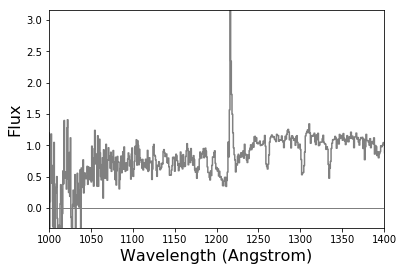

In [16]:
stack.plot(xlim=(1000,1400))
plt.show()